In [ ]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import ase.io as io

from abtem.parametrizations import LobatoParametrization

from ase.io import read
from ase.visualize import view
from ase.io import write

pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option('display.max_columns', 15)

abtem.config.set({"local_diagnostics.progress_bar": False});

In [ ]:
atoms = io.read(r'C:\Users\Joshu\Desktop\Models\Al.cfg')

view(atoms)

In [ ]:
symbols = ["Al"]
parametrization = LobatoParametrization()

potentials = parametrization.line_profiles(symbols, cutoff=2, name="potential")
scattering_factor = parametrization.line_profiles(
    symbols, cutoff=3, name="scattering_factor"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
visualization = potentials.show(ax=ax1)
visualization.set_ylim([0, 2e3])

scattering_factor.show(legend=True, ax=ax2);

In [ ]:
potential_infinite = abtem.Potential(
    repeated_atoms,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="infinite",
)

visualization = potential_infinite[:5].show(
    project=False,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
);

In [ ]:
probe = abtem.Probe(
    sampling=0.05,
    extent=20,
    energy=200e3,
    semiangle_cutoff=20,
    C10=0,
    Cs=-50e-6 * 1e10,
)

In [34]:
atoms.cell

Cell([1.0, 1.0, 1.0])

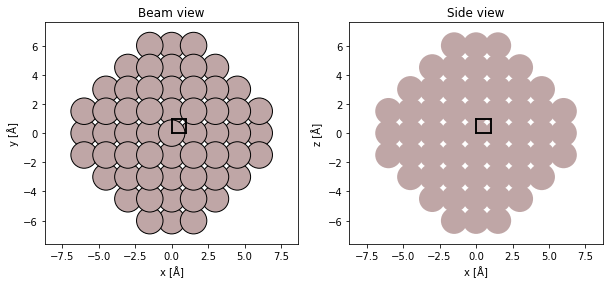

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view")
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", linewidth=0);

In [36]:
potential = abtem.Potential(atoms, slice_thickness=1.0 / 2, sampling=0.5)

plane_wave = abtem.PlaneWave(energy=200e3)

In [37]:
exit_wave = plane_wave.multislice(potential)

In [38]:
exit_wave.compute();

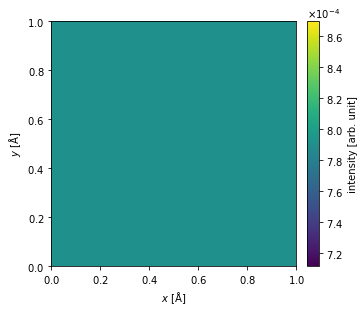

In [39]:
exit_wave.intensity().show(cbar=True);

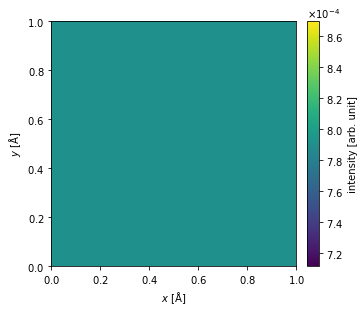

In [40]:
exit_wave.apply_ctf(defocus=-50, semiangle_cutoff=20).intensity().show(cbar=True);

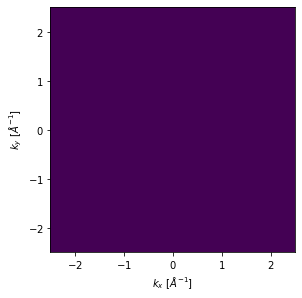

In [44]:
diffraction_patterns = exit_wave.diffraction_patterns()
diffraction_patterns.block_direct().crop(60).show();

In [45]:
probe = abtem.Probe(energy=100e3, semiangle_cutoff=9.0)

In [48]:
sampling = probe.aperture.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

Nyquist sampling = 1.028 Å/pixel


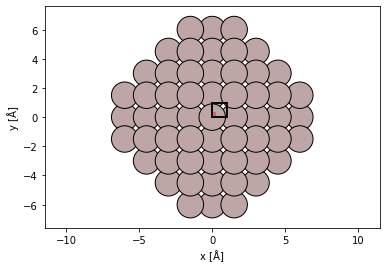

In [49]:
grid_scan = abtem.GridScan(
    start=[0, 0],
    end=[1 / 5, 1 / 3],
    sampling=sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(atoms)
grid_scan.add_to_plot(ax)

In [50]:
exit_waves_line = probe.multislice(potential=potential, scan=grid_scan)

In [51]:
bright = abtem.AnnularDetector(inner=0, outer=30)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=90, outer=200)

print(
    f"Maximum simulated scattering angle = {min(exit_waves_line.cutoff_angles):.1f} mrad"
)

Maximum simulated scattering angle = 37.0 mrad


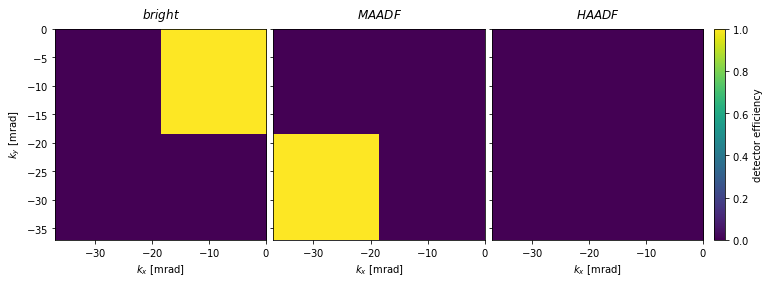

In [52]:
bright_region = bright.get_detector_region(exit_waves_line)
maadf_region = maadf.get_detector_region(exit_waves_line)
haadf_region = haadf.get_detector_region(exit_waves_line)

stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), ("bright", "MAADF", "HAADF")
)

visualization = stacked_regions.show(
    explode=True, cbar=True, common_color_scale=True, units="mrad", figsize=(12, 4)
)

In [54]:
all_detectors = [bright, maadf, haadf]

measurements = probe.scan(potential, detectors=all_detectors, scan=grid_scan).compute();

RuntimeError: Outer integration limit cannot exceed the maximum simulated angle (120 mrad > 37.014365951263734 mrad), please increase the number of grid points.